In [1]:
%matplotlib inline
import torch
from sebm.cebm_sgld import SGLD_sampler
from sebm.models import CEBM_1ss, CEBM_2ss

dataset = 'flowers102' # 'mnist'
if dataset == 'mnist':
    input_channels, im_height, im_width = 1, 28, 28
else:
    input_channels, im_height, im_width = 3, 32, 32
device = torch.device('cuda:0')
ss = 2
seed = 1
lr = 5e-5
latent_dim = 128
data_noise_std = 3e-2
sgld_noise_std = 7.5e-3
sgld_num_steps = 50
reg_alpha = 5e-3
activation = 'Swish'
buffer_init = True
buffer_dup_allowed = True
load_version = 'cebm-ss=%s-dataset=%s-seed=%s-lr=%s-latentdim=%s-data_noise_std=%s-sgld_noise_std=%s-sgld_lr=2.0-sgld_num_steps=%s-buffer_size=5000-buffer_percent=0.95-buffer_init=%s-dup_allowed=%s-reg_alpha=%s-act=%s-arch=simplenet' % (ss, dataset, seed, lr, latent_dim, data_noise_std, sgld_noise_std, sgld_num_steps, buffer_init, buffer_dup_allowed, reg_alpha, activation)

print('Init EBM..')
ebm = CEBM_2ss(arch='simplenet',
               device=device,
               optimize_priors=False,
               im_height=im_height, 
               im_width=im_width, 
               input_channels=input_channels, 
               channels=[64,64,32,32], 
               kernels=[3,4,4,4], 
               strides=[1,2,2,2], 
               paddings=[1,1,1,1], 
               hidden_dim=[128],
               latent_dim=latent_dim,
               activation=activation)
ebm = ebm.cuda().to(device)
print('Loading trained weights..')
ebm.load_state_dict(torch.load('../weights/checkpoint-%s' % load_version)['model_state_dict'])

Init EBM..
Loading trained weights..


<All keys matched successfully>

In [2]:
print('Init sgld sampler..')
sgld_sampler = SGLD_sampler(device=device,
                            input_channels=input_channels,
                            noise_std=1e-3,
                            lr=2.0,
                            pixel_size=im_height,
                            buffer_size=1000,
                            buffer_percent=0.95,
                            buffer_init=False,
                            buffer_dup_allowed=False)

test_batch_size = 100
images_ebm = sgld_sampler.sample(ebm=ebm, 
                                      batch_size=test_batch_size, 
                                      num_steps=1000,
                                      pcd=False)

Init sgld sampler..


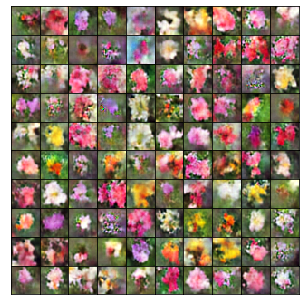

In [4]:
from sebm.eval import plot_samples, compress_tsne, plot_tsne
plot_samples(images_ebm, fs=4)

In [ ]:
data_dir = '../../../sebm_data/'
num_classes = 10
zs2, ys = compress_tsne(dataset, data_dir, ebm)
plot_tsne(num_classes, zs2, ys)